In [5]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import os, sys


# Get the path two folders up
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../daeFinder"))
# Add the path to the sys.path
sys.path.append(path_to_add)

# Generating data

#### Plotting solutions to different IC

In [18]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the Lorenz system
def lorenz_system(t, state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Initial condition and time span
IC_list = [[1.0, 1.0, 1.0]]
t_span = (0, 40)
t_eval = np.linspace(t_span[0], t_span[1], 10000)


def get_block_symbol(feature_list):
    return ["[{}]".format(feat) for feat in feature_list]
data_matrix_df_list = []
for IC_ in IC_list:
    # data_matrix_df_list.append(solveMM(IC, k_rates, time_grid_1, "dense"))
    solution = solve_ivp(lorenz_system, t_span, IC_, t_eval=t_eval)
    sol_df = pd.DataFrame(solution.y.transpose(), columns=["X", "Y", "Z"])
    sol_df["t"] = solution.t
    data_matrix_df_list.append(sol_df)

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

,X,Y,Z,t
0,1.00000000,1.00000000,1.00000000,0.00000000
1,1.00203407,1.10391248,0.99357792,0.00400040
2,1.00804617,1.20789257,0.98765648,0.00800080
3,1.01791059,1.31233304,0.98225495,0.01200120
4,1.03151432,1.41762349,0.97739795,0.01600160
...,...,...,...,...
9995,-1.41600536,-1.83660644,16.38832787,39.98399840
9996,-1.43368306,-1.89577174,16.22501135,39.98799880
9997,-1.45299730,-1.95651566,16.06390852,39.99199920
9998,-1.47396840,-2.01890527,15.90502805,39.99599960


<Axes: >

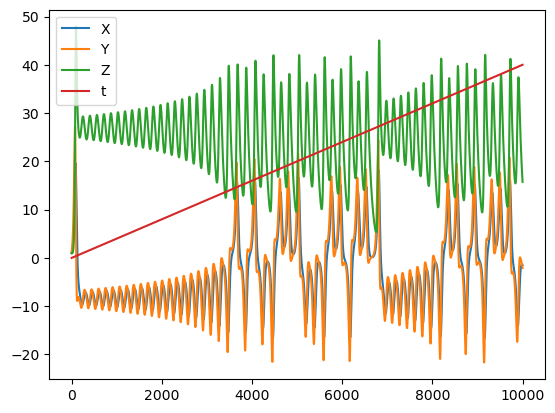

In [19]:
data_matrix_df.plot()

#### Adding noise

In [20]:
from dae_finder import add_noise_to_df
noise_perc = 0


data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["t"]
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
    noisy_data_df["t"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df

# Data preprocessing

## Smoothening data using splines

# Defining Cadidate library (RHS of equations)

### Using polynomial features inspired from mass action kinetics

In [41]:
from dae_finder import PolyFeatureMatrix

poly_degree = 3

poly_feature_ob = PolyFeatureMatrix(poly_degree)

# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df.drop(["t"], axis=1))



#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,X,Y,Z,X^2,X Y,X Z,Y^2,Y Z,Z^2,X^3,X^2 Y,X^2 Z,X Y^2,X Y Z,X Z^2,Y^3,Y^2 Z,Y Z^2,Z^3
0,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000
1,1.00203407,1.10391248,0.99357792,1.00407228,1.10615792,0.99559893,1.21862277,1.09682307,0.98719708,1.00611464,1.10840793,0.99762405,1.22110154,1.09905408,0.98920511,1.34525289,1.21079668,1.08977918,0.98085722
2,1.00804617,1.20789257,0.98765648,1.01615707,1.21761147,0.99560333,1.45900446,1.19298293,0.97546533,1.02433324,1.22740858,1.00361412,1.47074385,1.20258187,0.98331409,1.76232065,1.44099521,1.17825732,0.96342466
3,1.01791059,1.31233304,0.98225495,1.03614197,1.33583770,0.99984771,1.72221801,1.28904562,0.96482478,1.05469989,1.35976334,1.01775558,1.75306395,1.31213319,0.98210536,2.26012359,1.69165715,1.26617143,0.94770391
4,1.03151432,1.41762349,0.97739795,1.06402180,1.46229894,1.00819998,2.00965636,1.38558229,0.95530675,1.09755373,1.50838230,1.03997272,2.07298932,1.42924798,0.98541259,2.84893606,1.96423400,1.35426529,0.93371485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.41600536,-1.83660644,16.38832787,2.00507118,2.60064456,-23.20596012,3.37312321,-30.09890848,268.57729038,-2.83919154,-3.68252664,32.85976393,-4.77636055,42.62021576,-380.30688297,-6.19509980,55.27984909,-493.27078063,4401.53269323
9996,-1.43368306,-1.89577174,16.22501135,2.05544712,2.71793584,-23.26152397,3.59395050,-30.75891806,263.25099342,-2.94685973,-3.89665858,33.34965293,-5.15258597,44.09853985,-377.41849050,-6.81330981,58.31188773,-499.06379478,4271.25035694
9997,-1.45299730,-1.95651566,16.06390852,2.11120115,2.84281196,-23.34081568,3.82795352,-31.42928854,258.04915706,-3.06756956,-4.13059810,33.91414211,-5.56200611,45.66667132,-374.94472790,-7.48945099,61.49189511,-504.87721605,4145.27805357
9998,-1.47396840,-2.01890527,15.90502805,2.17258285,2.97580257,-23.44350877,4.07597848,-32.11074493,252.96991724,-3.20231847,-4.38623896,34.55499114,-6.00786349,47.33022337,-372.86966451,-8.22901444,64.82855212,-510.72229877,4023.49362926


## Finding time derivatives

In [34]:

def central_difference(x, dt):
    x = np.asarray(x)
    x_dot = np.zeros_like(x)

    # Central difference for interior points
    x_dot[1:-1] = (x[2:] - x[:-2]) / (2 * dt)

    # Forward difference for the first point
    x_dot[0] = (x[1] - x[0]) / dt

    # Backward difference for the last point
    x_dot[-1] = (x[-1] - x[-2]) / dt

    return x_dot


In [38]:
data_matrix_states = data_matrix_df.drop(["t"], axis=1)
dt = data_matrix_df["t"][1] - data_matrix_df["t"][0]
x_dot_df = pd.DataFrame(central_difference(data_matrix_states, dt),  columns=["X_dot", "Y_dot", "Z_dot"])

In [39]:
x_dot_df

,X_dot,Y_dot,Z_dot
0,0.50846722,25.97552285,-1.60535964
1,1.00567013,25.98397256,-1.54278526
2,1.98436646,26.04996432,-1.41523018
3,2.93322647,26.21374345,-1.28218881
4,3.85541544,26.47451537,-1.14231376
...,...,...,...
9995,-4.22072494,-14.59753773,-41.10074572
9996,-4.62352972,-14.98715350,-40.54836307
9997,-5.03516376,-15.39015148,-39.99391325
9998,-5.44949507,-15.81235018,-39.43715508


## Cost function 

In [ ]:
X_dot = linear combination of terms in candidate library full 



Y_dot = linear combination of terms in candidate library full 
D_dot = linear combination of terms in candidate library full 

In [ ]:
Setup loss/cost function for X_dot. (without using regression package). 


1. Write the loss function. 


Loss_function(parameters, candidate_library_full) = (X_dot - p_1*x + p_2*y+....)^2 + beta*||parameters||

minimize Loss_function with respect to p. (use scipy minimizer) 

## Next step

In [ ]:
Try adding degree into optimization. 